In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [ ]:
df = pd.read_excel('premiums.xlsx')
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [ ]:
df.shape

(50000, 13)

In [ ]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount'],
      dtype='object')

In [ ]:
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount'],
      dtype='object')

## **Handle NA Values**

In [ ]:
df.isnull().sum()

,0
age,0
gender,0
region,0
marital_status,0
number_of_dependants,0
bmi_category,0
smoking_status,11
employment_status,2
income_level,13
income_lakhs,0


In [ ]:
null_columns = df.columns[df.isnull().sum() > 0]
null_columns_types = df[null_columns].dtypes

print(null_columns_types)

smoking_status       object
employment_status    object
income_level         object
dtype: object


In [ ]:
df['smoking_status'].fillna(df['smoking_status'].mode()[0], inplace=True)
df['employment_status'].fillna(df['employment_status'].mode()[0], inplace=True)
df['income_level'].fillna(df['income_level'].mode()[0], inplace=True)

In [ ]:
df.isnull().sum()

,0
age,0
gender,0
region,0
marital_status,0
number_of_dependants,0
bmi_category,0
smoking_status,0
employment_status,0
income_level,0
income_lakhs,0


In [ ]:
df.shape

(50000, 13)

## **Check for duplicates**

In [ ]:
df.drop_duplicates(inplace = True)
df.duplicated().sum()

0

In [ ]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,50000.000000,50000.000000,50000.000000,50000.000000
mean,34.593480,1.712080,23.018200,15768.116320
std,15.000437,1.498248,24.219197,8419.839675
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13929.000000
75%,45.000000,3.000000,31.000000,22275.250000
max,356.000000,5.000000,930.000000,43471.000000


* In the 'age' column, the max age is 356 years which is definelty an outlier.

* In the 'numer_of_dependants' column the minum number of dependants is -3 which is not practically possible (there can be no dependants at all but there cannot be negative dependants), which is definetly an outlier

* In the 'income_lakhs' column, the min is 1 lakh, but max is 9.3 cr. This gives a skewed distribution.

So, these need to be handled.

In [ ]:
df[df.number_of_dependants<0].shape

(72, 13)

In [ ]:
#let us check the unique values for the above cell (where the number_of_dependants are <0)
df[df.number_of_dependants<0].number_of_dependants.unique()

array([-3, -1])

In [ ]:
#Converting the above rows that have negative value for number of dependants to positive value
df['number_of_dependants'] = df['number_of_dependants'].apply(lambda x: abs(x))

In [ ]:
df['number_of_dependants'].describe()

,number_of_dependants
count,50000.000000
mean,1.717520
std,1.492009
min,0.000000
25%,0.000000
50%,2.000000
75%,3.000000
max,5.000000


## **Exploratory Data Analysis**

### **Outleir treatment**

#### **1. 'age' column**


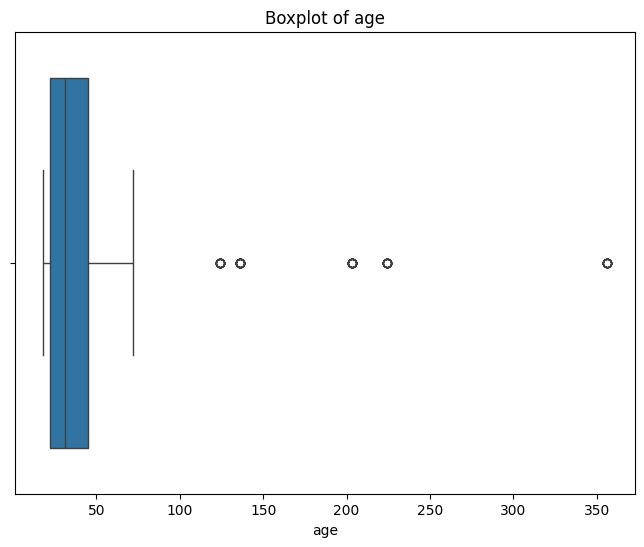

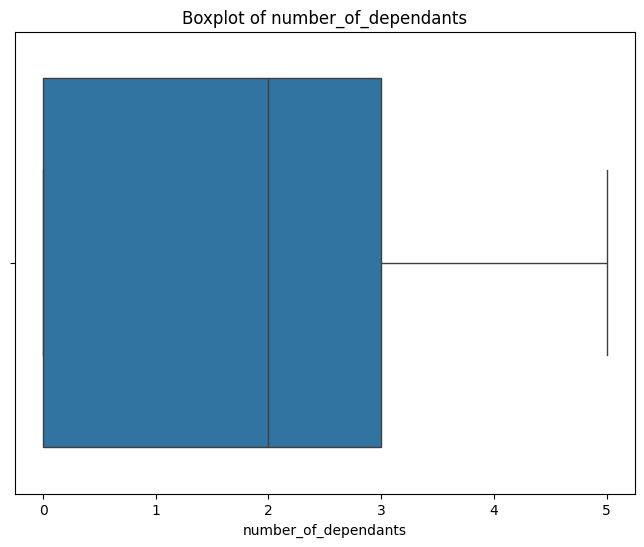

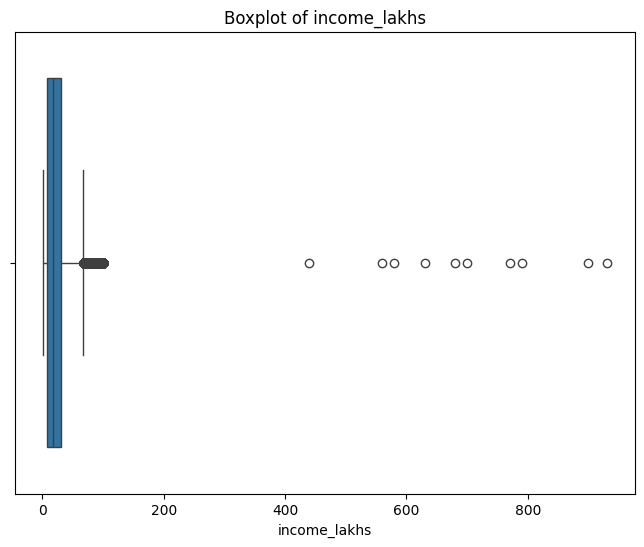

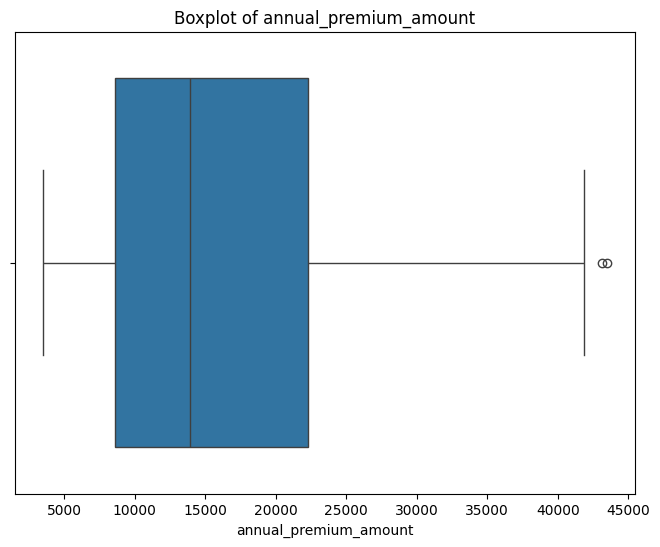

In [ ]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=np.number).columns

# Create box plots for each numeric column
for col in numeric_cols:
  plt.figure(figsize=(8, 6))
  sns.boxplot(x=df[col])
  plt.title(f'Boxplot of {col}')
  plt.show()


In [ ]:
# Option 1: Include all the records that have age <=100 only
df = df[df['age'] <= 100]

# Calculate the IQR (Interquartile Range)
# Q1 = df['age'].quantile(0.25)
# Q3 = df['age'].quantile(0.75)
# IQR = Q3 - Q1

# # Define the lower and upper bounds
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Identify outliers
# outliers = df[(df['age'] < lower_bound) | (df['age'] > upper_bound)]

# # Handle outliers (e.g., capping or removal)
# # Option 2: Capping
# df['age'] = np.clip(df['age'], lower_bound, upper_bound)

# Option 3: Removal (if appropriate)
# df = df[(df['age'] >= lower_bound) & (df['age'] <= upper_bound)]

In [ ]:
df['age'].describe()

,age
count,49942.000000
mean,34.403648
std,13.682354
min,18.000000
25%,22.000000
50%,31.000000
75%,45.000000
max,72.000000


#### **2. 'income_lakhs'**

<Axes: xlabel='income_lakhs', ylabel='Count'>

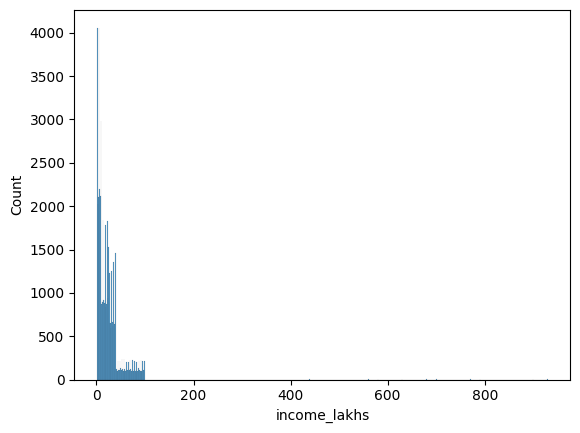

In [ ]:
sns.histplot(df['income_lakhs'])

In [ ]:
#Define a function and call IQR method to get IQR bounds
def iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

In [ ]:
iqr_bounds(df['income_lakhs'])

(-29.0, 67.0)

The lower bound is -29.0. The min is 1 lakh. So, this need not be handled. But the upper bound is 67.0 lakhs which is not very high salary. So, we will do some trial and error and talk to business stake holders what amount of income they want us to consider as upper bound. Here I am considering 1cr as upper bound.

#### **Find the quantile value that has 100.0 in income_lakhs value (1cr as income) as upper bound**

In [ ]:
# # find the quantile value that has 100.0 in income_lakhs value (1cr as income) as upper bound

# # First, sort the column
# sorted_income = df['income_lakhs'].sort_values()

# # Find the quantile where the value is 100.0
# quantile_value = df['income_lakhs'].quantile(q=sorted_income.searchsorted(100.0) / len(sorted_income))

# print(f"The quantile value for an upper bound of 100.0 in Income_Level is: {quantile_value}")

* searchsorted(100.0) finds the index position where 100.0 would be inserted to maintain order.

* Dividing by len(sorted_income) normalizes this index to the range [0, 1], which is what quantile expects.

* quantile(q=...) then gives the quantile corresponding to this normalized index.

This will give you the quantile in which 100.0 is the upper bound for income_lakhs column.

##### **OR THE BELOW CODE CAN ALSO BE USED**

In [ ]:
# Calculate the exact quantile for the value 100.0 in income_lakhs
quantile_value = df['income_lakhs'].rank(pct=True)[df['income_lakhs'] == 100.0].min()

print(f"The quantile value corresponding to an upper bound of 100.0 in income_lakhs is: {quantile_value}")

The quantile value corresponding to an upper bound of 100.0 in income_lakhs is: 0.9988086179968764


* rank(pct=True): This ranks the data in the income_lakhs column and normalizes it to a percentage (0 to 1 scale).

* df['income_lakhs'] == 100.0: This condition finds the positions in the DataFrame where the value is exactly 100.0.

* .min(): If there are multiple occurrences of 100.0, .min() returns the smallest rank (i.e., the lowest quantile) where 100.0 appears.

This method will give us the correct quantile where 100.0 is the upper bound in our income_lakhs data.

In [ ]:
quantile_threshold = df['income_lakhs'].quantile(quantile_value)
quantile_threshold

100.0

In [ ]:
df[df.income_lakhs > quantile_threshold]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
2635,51,Male,Northwest,Married,4,Obesity,No Smoking,Self-Employed,> 40L,560,High blood pressure,Gold,30692
4220,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,> 40L,440,No Disease,Silver,10636
7775,35,Female,Northeast,Unmarried,0,Overweight,No Smoking,Salaried,> 40L,630,Diabetes,Gold,24010
9021,43,Male,Southeast,Married,3,Obesity,Regular,Salaried,> 40L,900,Diabetes & Thyroid,Gold,30848
10337,37,Female,Southeast,Married,3,Normal,No Smoking,Freelancer,> 40L,930,Diabetes,Silver,15945
10639,20,Female,Southwest,Unmarried,0,Normal,No Smoking,Freelancer,> 40L,580,Thyroid,Silver,12888
11456,21,Female,Southwest,Unmarried,0,Obesity,No Smoking,Freelancer,> 40L,700,No Disease,Bronze,7424
15437,21,Female,Southeast,Unmarried,0,Normal,Occasional,Salaried,> 40L,790,No Disease,Silver,7586
35446,59,Male,Northwest,Married,2,Obesity,Occasional,Self-Employed,> 40L,770,Thyroid,Gold,31115
40970,48,Male,Northeast,Married,4,Obesity,No Smoking,Salaried,> 40L,680,No Disease,Gold,28926


In [ ]:
df[df.income_lakhs > quantile_threshold].shape

(10, 13)

There are just 10 records that are above threshold. These can either be dropped or imputation (like mean and median) can be performed on the data.

In [ ]:
## The code to perform imputation is here
# median_income = df['income_lakhs'].median()
# df.loc[df['income_lakhs'] > quantile_threshold, 'income_lakhs'] = median_income

In [ ]:
## Just dropping those 10 records
df = df[df['income_lakhs'] <= quantile_threshold]
df['income_lakhs'].describe()

,income_lakhs
count,49932.000000
mean,22.887006
std,22.168871
min,1.000000
25%,7.000000
50%,17.000000
75%,31.000000
max,100.000000


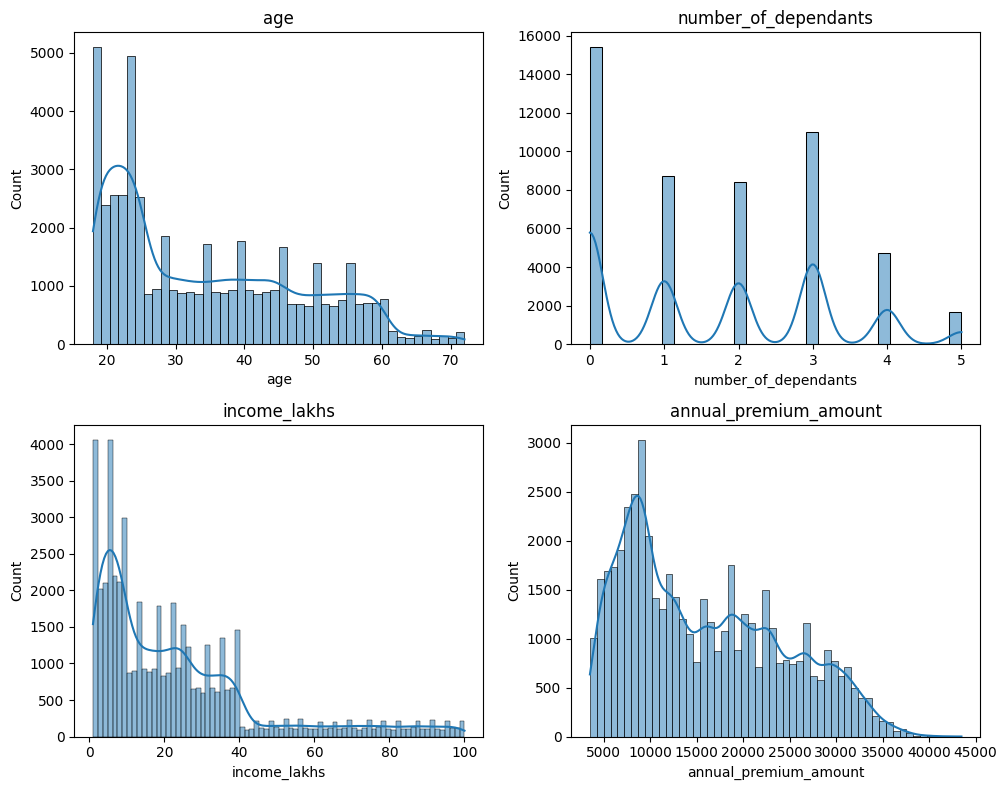

In [ ]:
#hist plot on numeric data
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(10, 8))

for i, col in enumerate(df.select_dtypes(include=np.number).columns):
  sns.histplot(df[col], ax=axs[i//2, i%2], kde = True)
  axs[i//2, i%2].set_title(col)
plt.tight_layout()
plt.show()

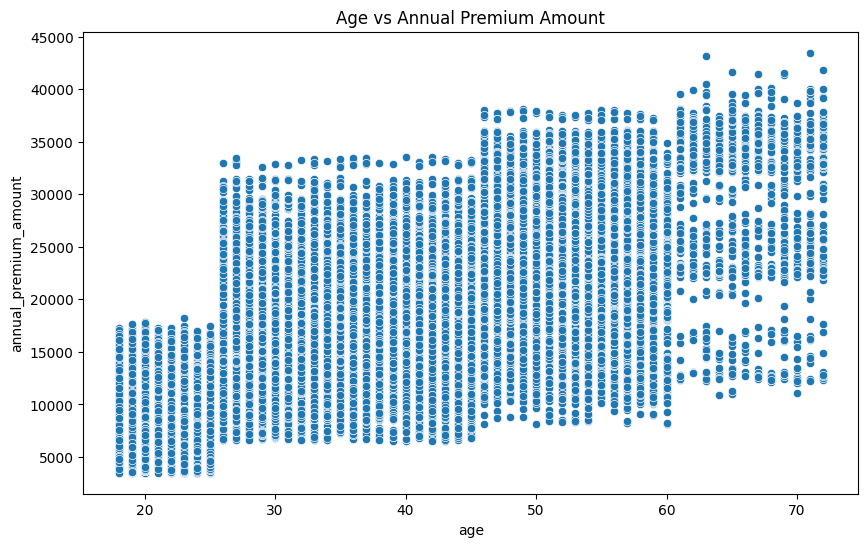

In [ ]:
#Scatterplot to see the relation between age and annual_premium_amount
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='annual_premium_amount', data=df)
plt.title('Age vs Annual Premium Amount')
plt.show()

As age increases, the annual_premium_amount increases.

In [ ]:
#Correlation between age and annual_premium_amount
df[['age', 'annual_premium_amount']].corr()

,age,annual_premium_amount
age,1.000000,0.767594
annual_premium_amount,0.767594,1.000000


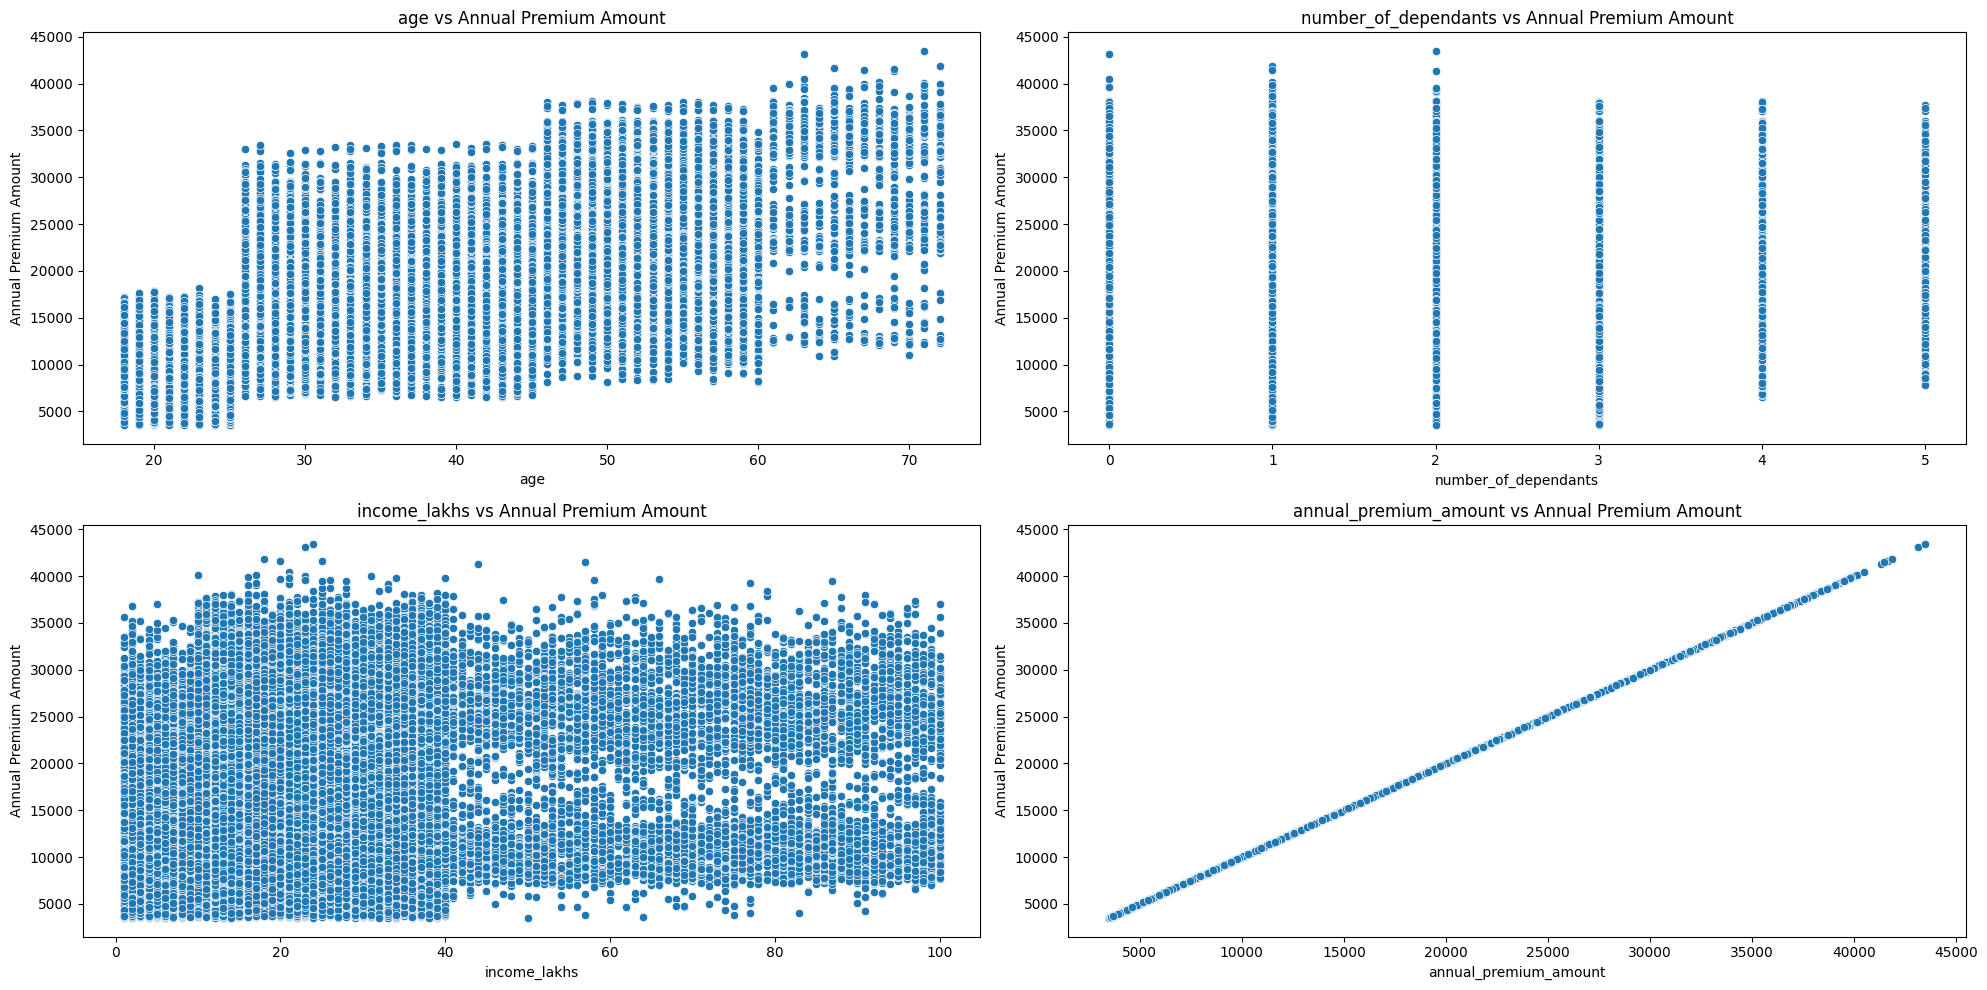

In [ ]:
#For loop for all numeric columns vs annual_premium_amount scatter plot with subplots

# Number of columns per row
n_cols = 2
# Calculate the number of rows needed
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

# Create subplots with the calculated number of rows and columns
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))

# Flatten the 1D array of axes if there are more than one row
if n_rows > 1:
  axs = axs.flatten()

# Loop through each column in the DataFrame

for ax, col in zip(axs, numeric_cols):
  sns.scatterplot(x=col, y='annual_premium_amount', data=df, ax=ax)
  ax.set_title(f'{col} vs Annual Premium Amount')
  ax.set_xlabel(col)
  ax.set_ylabel('Annual Premium Amount')

# Remove any empty subplots if there are fewer columns than rows
for ax in axs[len(numeric_cols):]:
  fig.delaxes(ax)

plt.tight_layout()
plt.show()

1. **age vs. annual_premium_amount:**

The scatter plot shows a somewhat clustered distribution with a few clear bands, suggesting that the premium amount might increase with age, but there are distinct groupings. The increase in premium seems more noticeable for middle-aged individuals.
This could indicate age brackets with different premium rates or policies.

2. **number_of_dependants vs. annual_premium_amount:**

The premium amount doesn't seem to vary much with the number of dependents. There are clear bands for each number of dependents, but they all overlap significantly.
This could imply that the number of dependents does not significantly impact the premium, or it could be due to categorical handling where premiums are flat across certain numbers of dependents.

3. **income_lakhs vs. annual_premium_amount:**

The relationship between income and premium is spread out, suggesting that as income increases, the premium amount also increases, but not in a strict linear fashion. There's a wide range of premiums for each income level.
This indicates that income might have some impact on premium, but other factors could be more influential.

4. **annual_premium_amount vs. annual_premium_amount:**

This plot should be a perfect diagonal line because it's plotting the variable against itself. It’s redundant and doesn’t provide any new information.

'age', 'income_lakhs' and 'annual_premium_amount' are right skewed.

In [ ]:
# # To handle this skewness

# # Apply log transformation to handle skewness
# df['age'] = np.log1p(df['age'])
# df['income_lakhs'] = np.log1p(df['income_lakhs'])
# df['annual_premium_amount'] = np.log1p(df['annual_premium_amount'])

# # Print hist plot on numeric data after transformation
# # Select only numeric columns
# numeric_cols = df.select_dtypes(include=np.number).columns

# # Create histograms for each numeric column
# for col in numeric_cols:
#   plt.figure(figsize=(8, 6))
#   sns.histplot(df[col], kde = True)
#   plt.title(f'Histogram of {col}')
#   plt.show()


In [ ]:
#Get categorical columns and print unique values in each of those columns
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
  print(f"{col}: {df[col].unique()}")

gender: ['Male' 'Female']
region: ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status: ['Unmarried' 'Married']
bmi_category: ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status: ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status: ['Salaried' 'Self-Employed' 'Freelancer']
income_level: ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history: ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan: ['Bronze' 'Silver' 'Gold']


smoking_status: ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking'] has 'Smoking=0' 'Does Not Smoke'
 'Not Smoking' values which means 'No Smoking'. This has to be handled.

In [ ]:
df['smoking_status'].replace({'Smoking=0': 'No Smoking',
                              'Does Not Smoke': 'No Smoking',
                              'Not Smoking':'No Smoking'},
                             inplace=True)

df['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [ ]:
df['gender'].value_counts(normalize = True)

,proportion
gender,
Male,0.549607
Female,0.450393


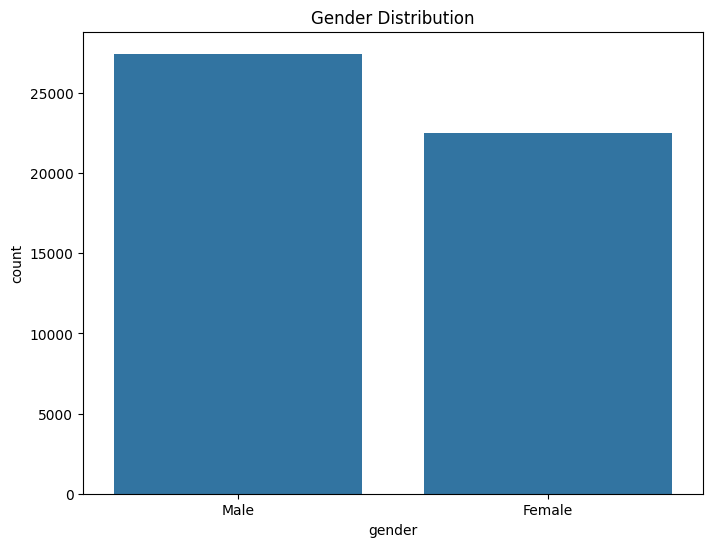

In [ ]:
#Plot bar chart for gender
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', data=df)
plt.title('Gender Distribution')
plt.show()

<ipython-input-39-f97c5b41dfaf>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right')
<ipython-input-39-f97c5b41dfaf>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right')
<ipython-input-39-f97c5b41dfaf>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right')
<ipython-input-39-f97c5b41dfaf>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right')
<ipython-input-39-f97c5b41dfaf>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right')
<ipython-input-39-f97c5b41dfaf>:9: UserWarning: FixedFormatter should 

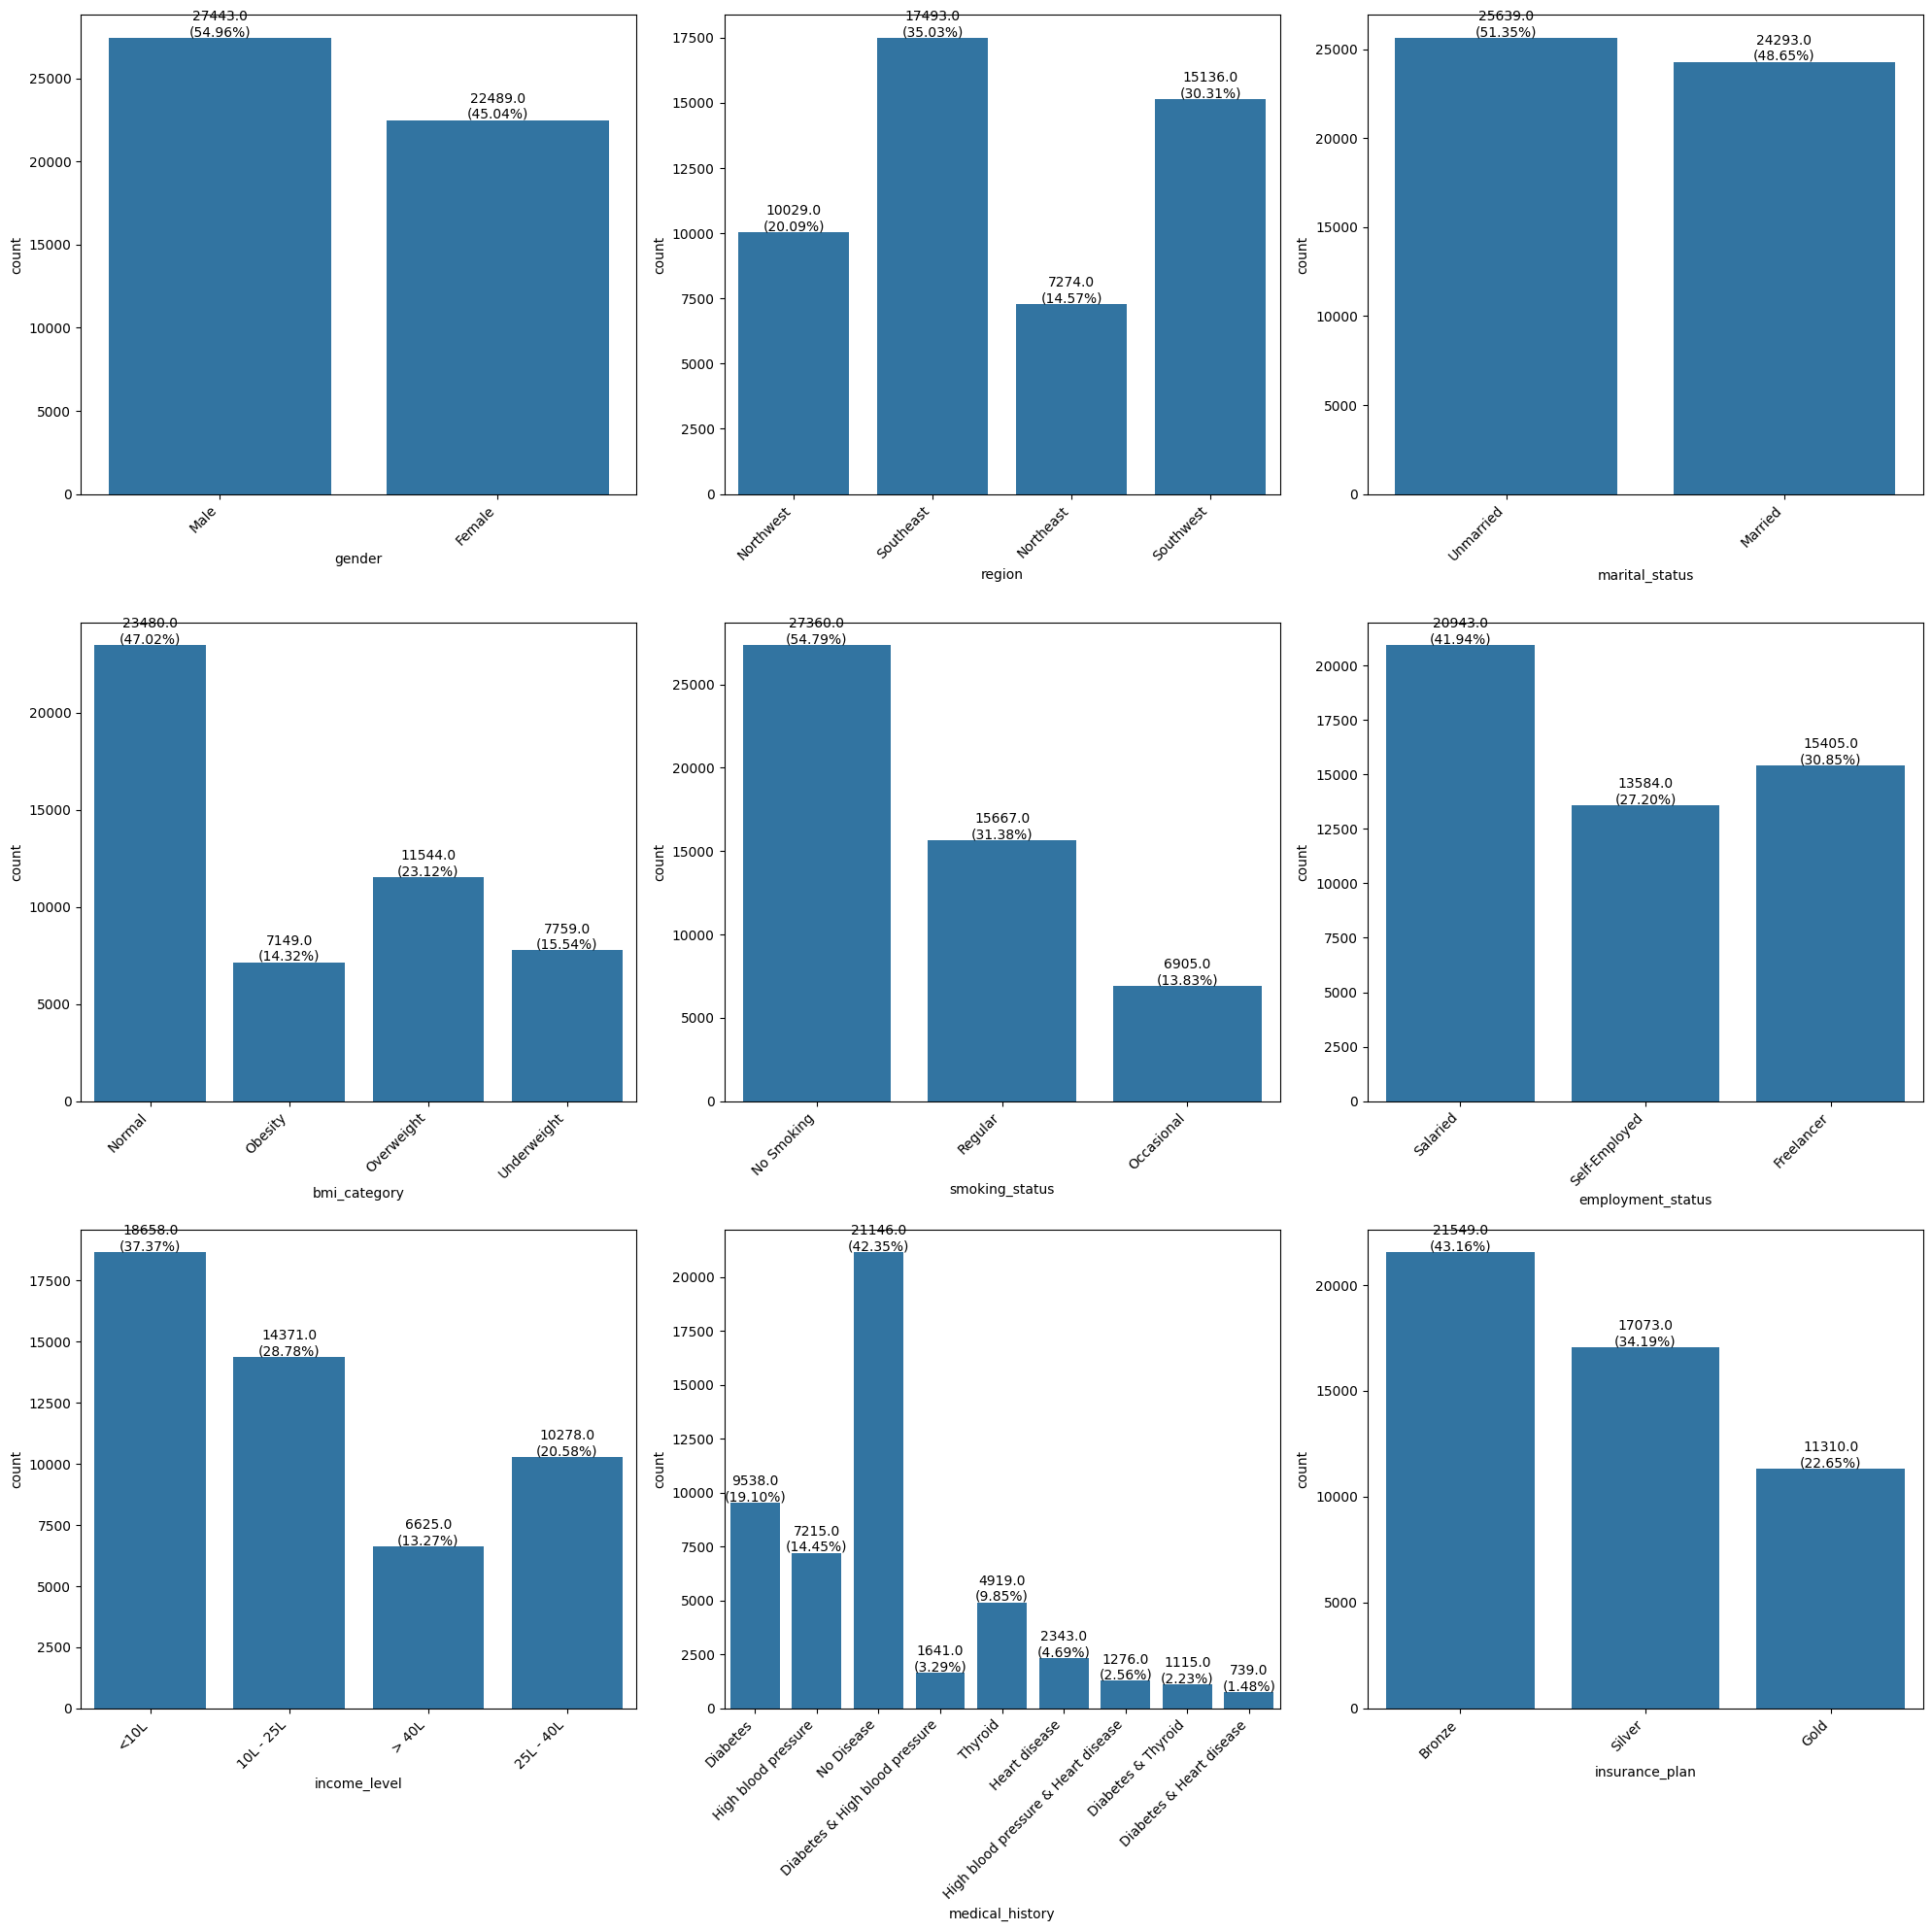

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
axs = axs.flatten()

# Rotate labels and plot bar chart with count and percentages in it
for i, col in enumerate(categorical_cols):
  counts = df[col].value_counts()
  percentages = counts / counts.sum()
  sns.countplot(x=col, data=df, ax=axs[i])
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right')
  for p in axs[i].patches:
    axs[i].annotate(f'{p.get_height()}\n({100*p.get_height()/len(df):.2f}%)',
     (p.get_x()+p.get_width()/2., p.get_height()), ha='center',
                    va='center', xytext=(0, 10), textcoords='offset points')
plt.tight_layout()
plt.show()

# for i, col in enumerate(categorical_cols):
#   sns.countplot(x=col, data=df, ax=axs[i])
#   axs[i].set_title(f'Distribution of {col}')
#   axs[i].set_xlabel(col)
#   axs[i].set_ylabel('Count')

# plt.tight_layout()
# plt.show()


In [ ]:
#Based on income_level, what kind of insurance plan people are getting
df.groupby('income_level')['insurance_plan'].value_counts(normalize = True)

income_level  insurance_plan
10L - 25L     Bronze            0.369355
              Silver            0.360657
              Gold              0.269988
25L - 40L     Silver            0.364857
              Bronze            0.358338
              Gold              0.276805
<10L          Bronze            0.655429
              Silver            0.294673
              Gold              0.049898
> 40L         Gold              0.551547
              Silver            0.398792
              Bronze            0.049660
Name: proportion, dtype: float64

Printing the same in more understandable format

In [ ]:
crosstab = pd.crosstab(df['income_level'], df['insurance_plan'])
crosstab

insurance_plan,Bronze,Gold,Silver
income_level,,,
10L - 25L,5308,3880,5183
25L - 40L,3683,2845,3750
<10L,12229,931,5498
> 40L,329,3654,2642


Less than 10L are mostly preferring Bronze plan.

Greater than 40L are mostly preferring Gold plan.

Text(0.5, 1.0, 'Distribution of Insurance Plans by Income Level')

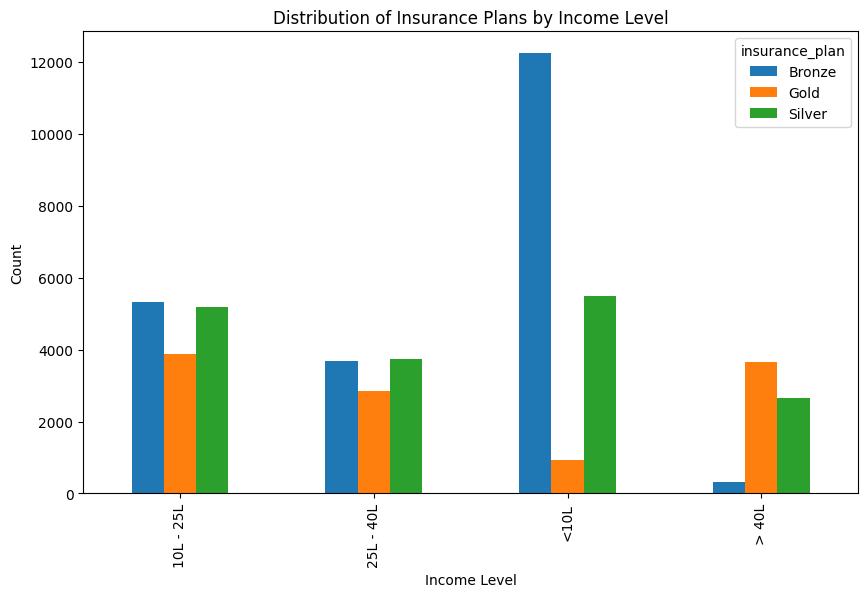

In [ ]:
crosstab.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Income Level')
plt.ylabel('Count')
plt.title('Distribution of Insurance Plans by Income Level')

<Axes: xlabel='insurance_plan', ylabel='income_level'>

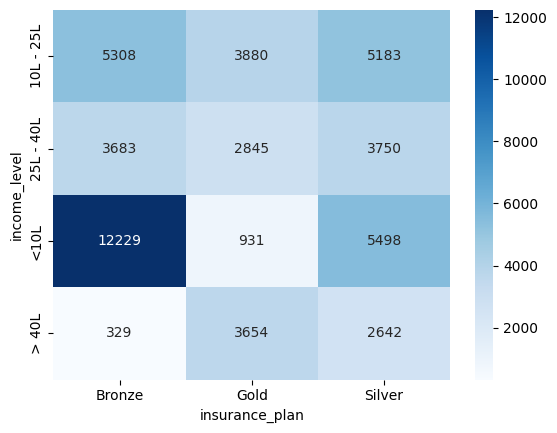

In [ ]:
sns.heatmap(crosstab, annot=True, cmap='Blues', fmt='g')

## **Feature Engineering**

Here, we are considering medical history also plays a major role whether person has to be given insurance or not. Let us just give risk_scores to each of the medical condition.

In [ ]:
df.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [ ]:
df['medical_history'].str.split(' & ', expand=True).apply(lambda x: x.str.lower())

,0,1
0,diabetes,None
1,diabetes,None
2,high blood pressure,None
3,no disease,None
4,high blood pressure,None
...,...,...
49995,no disease,None
49996,thyroid,None
49997,no disease,None
49998,no disease,None


In [ ]:
df[['disease 1', 'disease 2']] = df['medical_history'].str.split(' & ', expand=True).apply(lambda x: x.str.lower())
df.sample(10)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease 1,disease 2
27833,19,Male,Southeast,Unmarried,1,Normal,No Smoking,Salaried,10L - 25L,25,No Disease,Bronze,5098,no disease,None
28397,20,Female,Southwest,Unmarried,2,Obesity,No Smoking,Freelancer,10L - 25L,25,Heart disease,Bronze,6995,heart disease,None
36353,22,Female,Southwest,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,24,No Disease,Silver,7414,no disease,None
45462,34,Female,Southwest,Married,3,Underweight,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9867,diabetes,None
30548,38,Male,Southeast,Unmarried,1,Underweight,Regular,Salaried,10L - 25L,21,High blood pressure,Silver,19617,high blood pressure,None
48894,48,Male,Northeast,Married,2,Overweight,No Smoking,Freelancer,> 40L,100,Diabetes,Silver,20445,diabetes,None
43005,26,Female,Southwest,Married,3,Normal,No Smoking,Salaried,<10L,7,Thyroid,Bronze,9529,thyroid,None
40568,23,Female,Northeast,Unmarried,0,Obesity,No Smoking,Freelancer,25L - 40L,36,No Disease,Bronze,7793,no disease,None
20420,44,Female,Northwest,Married,4,Normal,No Smoking,Freelancer,<10L,1,Diabetes,Bronze,9527,diabetes,None
4731,54,Male,Northwest,Married,3,Underweight,No Smoking,Freelancer,25L - 40L,26,Diabetes,Bronze,11146,diabetes,None


In [ ]:
risk_scores = {
    "diabetes":6,
    "heart disease":8,
    "high blood pressure":6,
    "thyroid":5,
    "no disease":0,
    "none":0
}

In [ ]:
df['disease 1'].fillna('none', inplace=True)
df['disease 2'].fillna('none', inplace=True)

df['total_risk_score'] = df['disease 1'].map(risk_scores) + df['disease 2'].map(risk_scores)
df.sample(10)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease 1,disease 2,total_risk_score
21108,45,Female,Northwest,Married,2,Normal,Regular,Self-Employed,10L - 25L,10,No Disease,Silver,16768,no disease,none,0
40369,41,Male,Southeast,Married,4,Normal,Regular,Salaried,<10L,5,Thyroid,Bronze,12242,thyroid,none,5
16485,20,Male,Southeast,Unmarried,1,Normal,No Smoking,Salaried,> 40L,45,No Disease,Silver,7389,no disease,none,0
49985,27,Male,Southwest,Unmarried,0,Normal,Regular,Freelancer,10L - 25L,14,Diabetes,Silver,18313,diabetes,none,6
35560,47,Female,Northwest,Married,3,Overweight,Regular,Self-Employed,25L - 40L,39,High blood pressure,Gold,31427,high blood pressure,none,6
16883,24,Female,Northeast,Unmarried,2,Normal,No Smoking,Self-Employed,> 40L,78,No Disease,Silver,11859,no disease,none,0
15313,72,Female,Southwest,Married,1,Underweight,No Smoking,Self-Employed,25L - 40L,31,Thyroid,Gold,32823,thyroid,none,5
24190,19,Male,Northeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,25,No Disease,Bronze,9415,no disease,none,0
45006,18,Female,Southwest,Unmarried,2,Normal,Occasional,Freelancer,<10L,7,No Disease,Bronze,5776,no disease,none,0
42694,18,Female,Southeast,Unmarried,1,Normal,Regular,Salaried,<10L,2,No Disease,Bronze,8692,no disease,none,0


In [ ]:
#Normalize the total_risk_score column
df['normalized_risk_score'] = (df['total_risk_score'] - df['total_risk_score'].min()) / (df['total_risk_score'].max() - df['total_risk_score'].min())
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease 1,disease 2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,none,0,0.000000
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,6,0.428571


In [ ]:
df.insurance_plan.unique()

array(['Bronze', 'Silver', 'Gold'], dtype=object)

This is ordinal data. We can use label encoding

In [ ]:
# #Label encoding insurance_plan column
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# df['insurance_plan'] = le.fit_transform(df['insurance_plan'])
# df.head()

The label encoder encodes categorical labels alphabetically. So, in this case, the labels 'Bronze', 'Silver', and 'Gold' are assigned numerical values based on their alphabetical order. {'Bronze': 0, 'Gold': 1, 'Silver': 2}

In [ ]:
# # Check the label encoding mapping
# label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
# print(label_mapping)

In [ ]:
df['insurance_plan'] = df['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease 1,disease 2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,1,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,1,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,2,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,3,20303,no disease,none,0,0.000000
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,2,13365,high blood pressure,none,6,0.428571


In [ ]:
df.income_level.unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

This is ordinal data (eg: 3<2<1 or Bachelors<Masters<PhD). So, data will be label encode for this column as well.

In [ ]:
# #Label encoding the income_level column
# df['income_level'] = le.fit_transform(df['income_level'])
# df.head()

# Or it can be mapped like this as well
df['income_level'] = df['income_level'].map({'<10L': 1, '10L - 25L' : 2, '25L - 40L' : 3, '> 40L' : 4})

In [ ]:
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease 1,disease 2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,1,6,Diabetes,1,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,1,6,Diabetes,1,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,2,20,High blood pressure,2,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,4,77,No Disease,3,20303,no disease,none,0,0.000000
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,4,99,High blood pressure,2,13365,high blood pressure,none,6,0.428571


In [ ]:
# # Check the label encoding mapping
# label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
# print(label_mapping)

In this case, the LabelEncoder assigns numerical labels based on the alphabetical order of the categories. Here's a breakdown of how the categories '10L - 25L', '25L - 40L', '<10L', and ' > 40L' were assigned numerical values:

**Why This Mapping Occurred:**

The LabelEncoder assigns numerical values based on the lexicographical (alphabetical) order of the category names (strings).

When comparing strings, even characters like < and > are taken into account in the sorting process.
Let's look at the string values in alphabetical order:

* '<10L': The < symbol comes first alphabetically, so this is assigned 2.
* '10L - 25L': The next string starts with a number, and since numbers come after symbols in the alphabetical order, this is assigned 0.
* '25L - 40L': This is next in the sequence and is assigned 1.
* ' > 40L': The > symbol comes last alphabetically, so this is assigned 3.

**Mapping Explanation:**
* '<10L' has the < symbol, which makes it alphabetically first, so it is assigned the highest label value (2 in this case).
* '10L - 25L' is alphabetically second, hence it gets the label 0.
* '25L - 40L' comes next alphabetically, and is assigned 1.
* ' > 40L' (note the space before >) comes last alphabetically, so it gets the label 3.

**General Behavior of LabelEncoder:**

The LabelEncoder does not take the inherent order or numerical meaning of the categories into account. It strictly uses alphabetical/lexicographical ordering when assigning labels. In this case, it treated <, 10L, 25L, and > 40L as strings and assigned labels based on that order, not based on any numerical relationship between them.

**Conclusion:**

If you want to preserve the logical numerical order of these income ranges (e.g., <10L < 10L - 25L < 25L - 40L < > 40L), you might need to use custom mapping or ordinal encoding, instead of relying on LabelEncoder.

Custom mapping looks like this: df['income_level'] = df['income_level'].map({'<10L':0, '10L-25L':1, '25L-40L':2, '>40L':3})

In [ ]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df1 = pd.get_dummies(df, columns = nominal_cols, drop_first=True, dtype=int)
df1.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease 1,disease 2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,6,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,diabetes,none,6,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,6,...,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,No Disease,3,20303,no disease,none,0,...,1,0,0,0,0,0,0,0,1,0
4,18,0,4,99,High blood pressure,2,13365,high blood pressure,none,6,...,0,0,1,0,1,0,0,1,0,1


In [ ]:
df1.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'medical_history', 'insurance_plan', 'annual_premium_amount',
       'disease 1', 'disease 2', 'total_risk_score', 'normalized_risk_score',
       'gender_Male', 'region_Northwest', 'region_Southeast',
       'region_Southwest', 'marital_status_Unmarried', 'bmi_category_Obesity',
       'bmi_category_Overweight', 'bmi_category_Underweight',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'employment_status_Salaried', 'employment_status_Self-Employed'],
      dtype='object')

In [ ]:
#Now that I have normalized_risk_score, drop the columns related to it like medical_history, disesae 1, disease 2
df1.drop(['medical_history', 'disease 1', 'disease 2','total_risk_score'], axis=1, inplace=True)
df1.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,3,20303,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


In [ ]:
df1.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'annual_premium_amount', 'normalized_risk_score',
       'gender_Male', 'region_Northwest', 'region_Southeast',
       'region_Southwest', 'marital_status_Unmarried', 'bmi_category_Obesity',
       'bmi_category_Overweight', 'bmi_category_Underweight',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'employment_status_Salaried', 'employment_status_Self-Employed'],
      dtype='object')

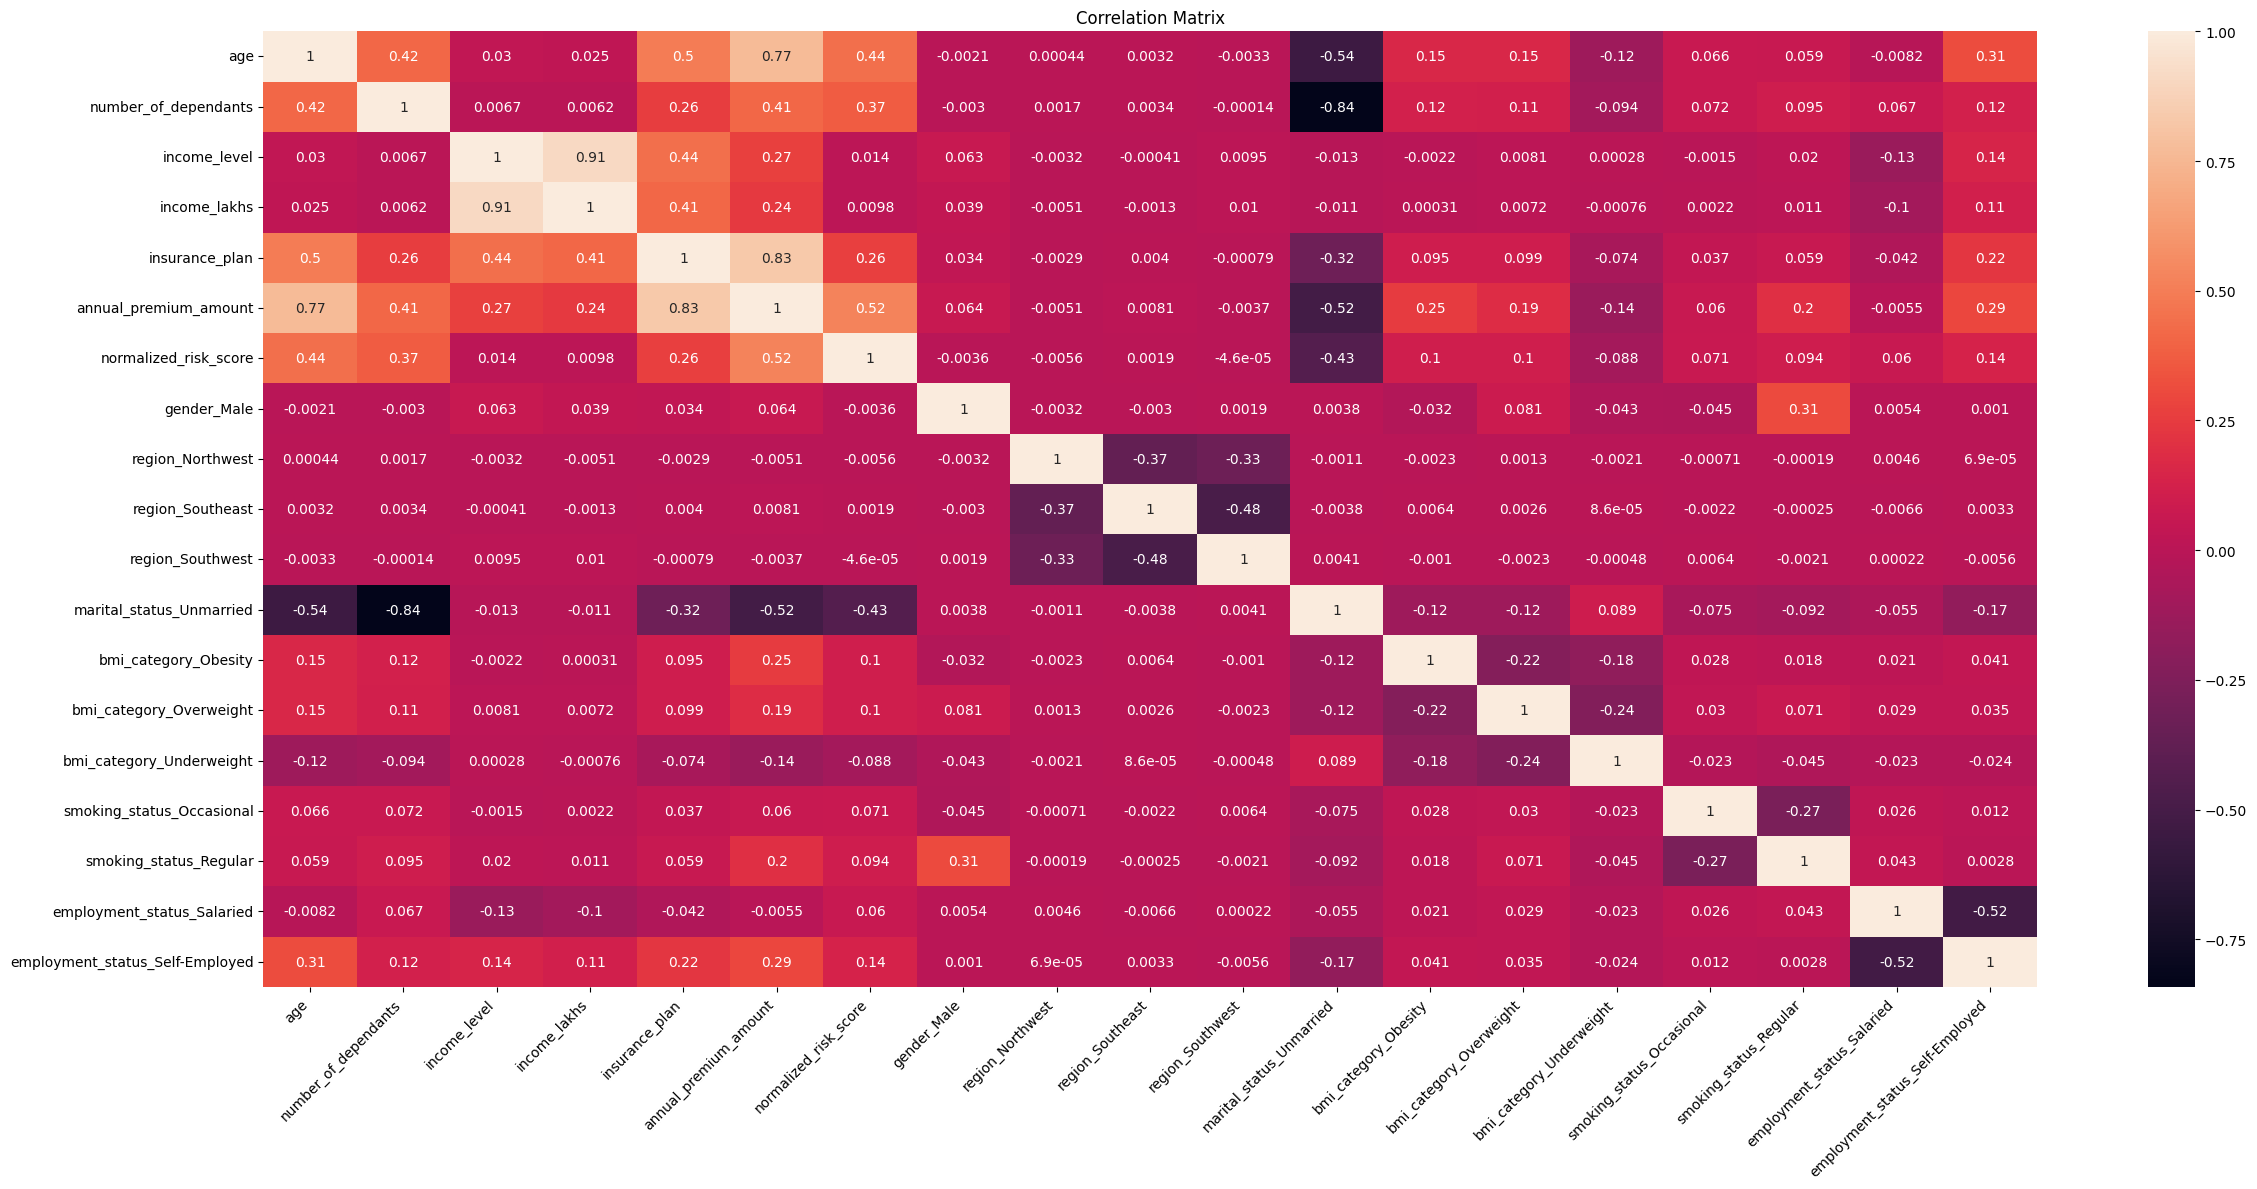

In [ ]:
#Check correlation between the columns
corr = df1.corr()

plt.figure(figsize=(25, 12))
sns.heatmap(corr, annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

Let us say 10 of my features are correlated and I want to get rid of multiple features, then we can use Cariance Inflation Factor. It will find out the relationship of one feature with rest of the features in an aggregate way.

In [ ]:
X = df1.drop('annual_premium_amount', axis=1)
y = df1['annual_premium_amount']

#Scaling the features
from sklearn.preprocessing import MinMaxScaler, StandardScaler
cols_to_scale = ['age','number_of_dependants','income_level','income_lakhs','insurance_plan']
scaler = MinMaxScaler()

# Scale the selected columns and update the DataFrame
X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale]) # Use cols_to_scale to select the columns to scale
X.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.148148,0.0,0.000000,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,0.000000,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,0.333333,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.222222,0.6,1.000000,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.000000,0.0,1.000000,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


A higher Variance Inflation Factor (VIF) indicates that a feature is highly correlated with other features in the dataset. VIF quantifies how much the variance of a feature’s estimated regression coefficient is increased due to multicollinearity (i.e., the correlation between features).

**Key Points:**

* VIF = 1: No correlation between the feature and other features.
* 1 < VIF < 5: Moderate correlation; usually acceptable.
* VIF > 5 (or 10): High correlation, indicating multicollinearity. A feature with a high VIF suggests that it can be predicted by other features, which can make the model unstable.


In feature reduction, features with high VIF values are often considered for removal because they add redundant information.









In [ ]:
# Now apply variance inflation factor
# from statsmodels.stats.outliers_influence import variance_inflation_factor
def calculate_vif(data):
  vif = pd.DataFrame()
  vif['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
  vif['Features'] = data.columns
  return vif

In [ ]:
calculate_vif(X)

,VIF,Features
0,4.567408,age
1,4.534621,number_of_dependants
2,12.448854,income_level
3,11.183615,income_lakhs
4,3.585440,insurance_plan
5,2.688263,normalized_risk_score
6,2.421187,gender_Male
7,2.101953,region_Northwest
8,2.921652,region_Southeast
9,2.670868,region_Southwest


income_level and income_lakhs have high VIF which means they are highly correlated.

In [ ]:
#Let us drop the column income_level (since it has highest VIF) and calculate VIF again
calculate_vif(X.drop('income_level', axis=1))

,VIF,Features
0,4.567408,age
1,4.534621,number_of_dependants
2,12.448854,income_level
3,11.183615,income_lakhs
4,3.585440,insurance_plan
5,2.688263,normalized_risk_score
6,2.421187,gender_Male
7,2.101953,region_Northwest
8,2.921652,region_Southeast
9,2.670868,region_Southwest


Not income_lakhs VIF score also decreased. It is always better to drop column one by one and calculate VIF.

Now that VIF has reduced, drop income_level column

In [ ]:
X_reduced = X.drop('income_level', axis=1)
calculate_vif(X_reduced)

,VIF,Features
0,4.567408,age
1,4.534621,number_of_dependants
2,12.448854,income_level
3,11.183615,income_lakhs
4,3.585440,insurance_plan
5,2.688263,normalized_risk_score
6,2.421187,gender_Male
7,2.101953,region_Northwest
8,2.921652,region_Southeast
9,2.670868,region_Southwest


## **Model Training**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42)

In [ ]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
model_lr.score(X_train, y_train)

0.928060743944233

In [ ]:
model_lr.score(X_test, y_test)

0.9284643235864346

In [ ]:
model_lr.coef_, model_lr.intercept_

(array([ 1.12216825e+04, -5.23158425e+02, -3.28739478e+02,  1.24822032e+04,
         4.85767029e+03,  1.36219124e+02, -7.02703488e+00,  5.32109763e+01,
        -2.45968840e+01, -8.43049753e+02,  3.35725787e+03,  1.60232126e+03,
         3.43852930e+02,  7.05266477e+02,  2.22812206e+03,  1.51574462e+02,
         3.88635940e+02]),
 4707.754679634159)

The first coefficient belongs to first column name age, second coef belongs to second column etc.

<Axes: xlabel='Coefficient', ylabel='Feature'>

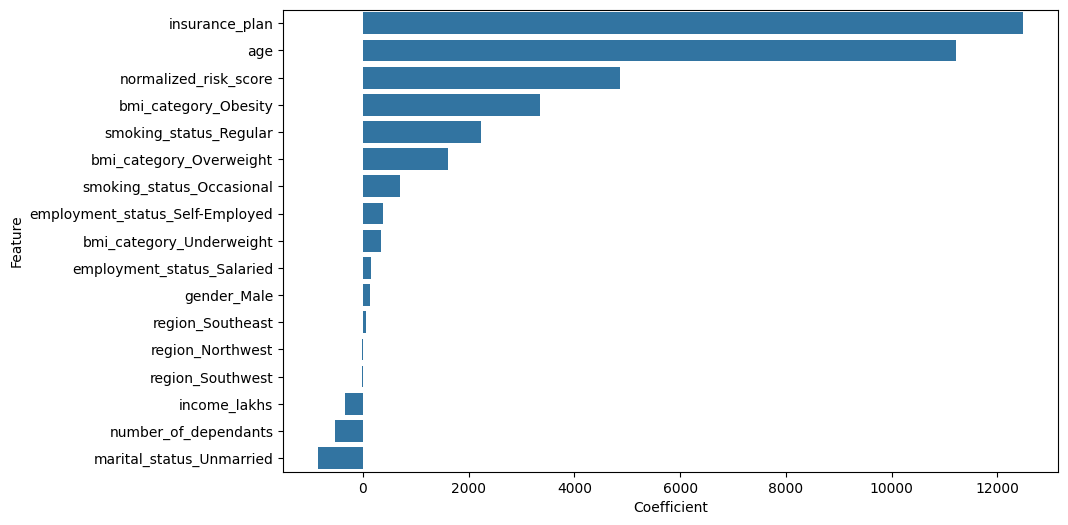

In [ ]:
# Printing these coefficients on a bar chart to check their contribution to final prediction
# Sort the value with highest feature importance and plot
coef_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': model_lr.coef_})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df)

# coefficients = model_lr.coef_
# feature_names = X_reduced.columns

# plt.figure(figsize=(10, 6))
# plt.barh(feature_names, coefficients)
# plt.xlabel('Coefficient Value')
# plt.ylabel('Feature')
# plt.title('Feature Importance')

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
regressors = {
    "Random Forest": RandomForestRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "ElasticNet": ElasticNet(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    # "Support Vector Machine": SVR(),
    "XGBoost": XGBRegressor()
}

In [ ]:
df_Results = pd.DataFrame(columns=['Model','MSE','R2'])
def evaluate_models(X_train, X_test, y_train, y_test, models, df_Results):
  for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    print(list(models.keys())[i])
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(np.sqrt(mse_train)))
    print("- R2 Score: {:.4f}".format(r2_train))
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(np.sqrt(mse_test)))
    print("- R2 Score: {:.4f}".format(r2_test))
    print('='*35)
    print('\n')
    df_Results = pd.concat([df_Results, pd.DataFrame({'Model': [list(models.keys())[i]], 'MSE': [np.sqrt(mse_test)], 'R2': [r2_test]})], ignore_index=True)
  return df_Results


In [ ]:
evaluate_models(X_train, X_test, y_train, y_test, regressors,df_Results)

Random Forest
Model performance for Training set
- Root Mean Squared Error: 489.1551
- R2 Score: 0.9966
Model performance for Test set
- Root Mean Squared Error: 1216.6457
- R2 Score: 0.9791




<ipython-input-75-3fc9c126f0ce>:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_Results = pd.concat([df_Results, pd.DataFrame({'Model': [list(models.keys())[i]], 'MSE': [np.sqrt(mse_test)], 'R2': [r2_test]})], ignore_index=True)


Decision Tree
Model performance for Training set
- Root Mean Squared Error: 228.9116
- R2 Score: 0.9993
Model performance for Test set
- Root Mean Squared Error: 1608.3794
- R2 Score: 0.9636


Linear Regression
Model performance for Training set
- Root Mean Squared Error: 2257.2517
- R2 Score: 0.9281
Model performance for Test set
- Root Mean Squared Error: 2253.2309
- R2 Score: 0.9285


Lasso
Model performance for Training set
- Root Mean Squared Error: 2257.2973
- R2 Score: 0.9281
Model performance for Test set
- Root Mean Squared Error: 2253.5667
- R2 Score: 0.9284


Ridge
Model performance for Training set
- Root Mean Squared Error: 2257.2523
- R2 Score: 0.9281
Model performance for Test set
- Root Mean Squared Error: 2253.2587
- R2 Score: 0.9285


ElasticNet
Model performance for Training set
- Root Mean Squared Error: 5723.7245
- R2 Score: 0.5374
Model performance for Test set
- Root Mean Squared Error: 5727.7985
- R2 Score: 0.5377


K-Nearest Neighbors
Model performance for Trai

,Model,MSE,R2
0,Random Forest,1216.645744,0.979144
1,Decision Tree,1608.379433,0.963551
2,Linear Regression,2253.230883,0.928464
3,Lasso,2253.566661,0.928443
4,Ridge,2253.258728,0.928463
5,ElasticNet,5727.798530,0.537740
6,K-Nearest Neighbors,2516.240833,0.910790
7,XGBoost,1159.567991,0.981055


Seems like Random Forest Regressor, XGBoost Regressor and Decision Tree Regressor performed well.

## **Hyperparameter tuning**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define models and their hyperparameter grids
models = {
    'RandomForest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [100, 200, 500],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(),
        'params': {
            'n_estimators': [100, 200, 500],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.3],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0]
        }
    },
    'DecisionTree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    }
}

# Function to perform RandomizedSearchCV for any given model and parameters
def tune_model_random(model, params, X_train, y_train):
    random_search = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=10, cv=5,
                                       scoring='r2', random_state=42)
    random_search.fit(X_train, y_train)

    print(f"Best Parameters for {model.__class__.__name__}: {random_search.best_params_}")
    print(f"Best r2: {random_search.best_score_}")
    return random_search.best_estimator_, random_search.best_score_

# Loop through models and tune hyperparameters using RandomizedSearchCV
best_models = {}
best_r2_score = -np.inf  # Initialize with a very low R² score
best_model_name = None
best_model = None

for model_name, model_info in models.items():
    print(f"Tuning {model_name}...")
    tuned_model, r2_score = tune_model_random(model_info['model'], model_info['params'], X_train, y_train)

    best_models[model_name] = tuned_model

    # Check if the current model has the best R² score
    if r2_score > best_r2_score:
        best_r2_score = r2_score
        best_model_name = model_name
        best_model = tuned_model

# Output the best model based on R² score
print(f"\nBest Model: {best_model_name}")
print(f"Best R² Score: {best_r2_score}")
print(f"Best Model Parameters: {best_model.get_params()}")


Tuning RandomForest...
Best Parameters for RandomForestRegressor: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10}
Best r2: 0.9813325421918263
Tuning XGBoost...
Best Parameters for XGBRegressor: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best r2: 0.9817240068818764
Tuning DecisionTree...
Best Parameters for DecisionTreeRegressor: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 10}
Best r2: 0.9800689935953514

Best Model: XGBoost
Best R² Score: 0.9817240068818764
Best Model Parameters: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 

All the three models performed well. XGBoost performed a bit better.



* Best Model: XGBoost
* Best R² Score: 0.9817240068818764
* Best Model Parameters: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 200, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 1.0, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}

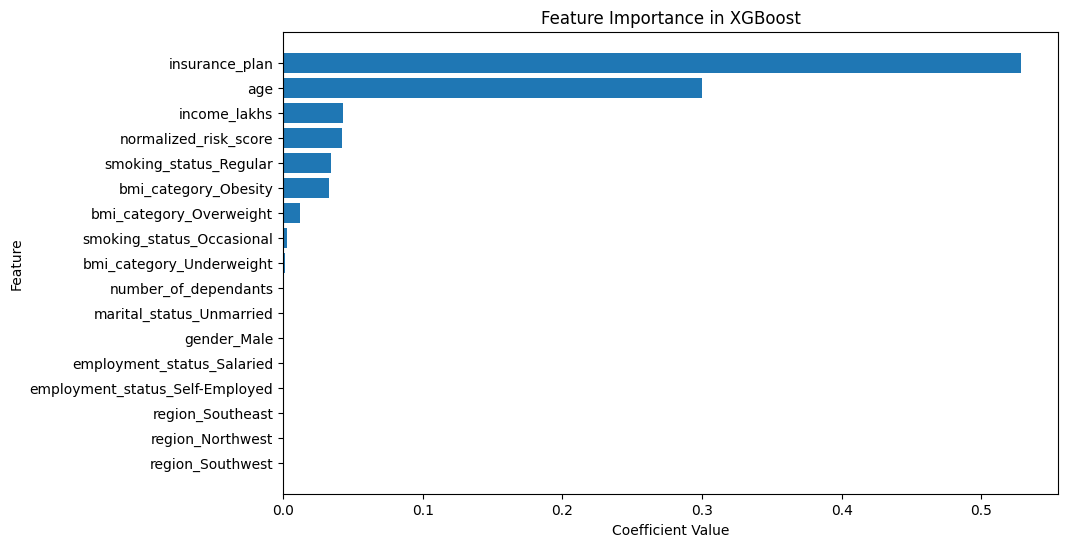

In [ ]:
feature_importances = best_model.feature_importances_
coed_df1 = pd.DataFrame(feature_importances, index = X_test.columns, columns = ['Coeffiecients'])
coed_df1 = coed_df1.sort_values(by='Coeffiecients', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(coed_df1.index, coed_df1['Coeffiecients'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance in XGBoost')
plt.show()

The model seems to give really good r2 score. But we cannot rely solely on r2 score. Further error analysis is required.

### **Error Analysis**

In [ ]:
y_pred = best_model.predict(X_test)
residuals = y_pred - y_test
residuals_pct = residuals*100/y_test

results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Residuals': residuals, 'Residuals %': residuals_pct})
results_df.head()

,Actual,Predicted,Residuals,Residuals %
15052,12732,10438.127930,-2293.872070,-18.016589
40389,18107,18556.802734,449.802734,2.484137
9843,30429,30471.687500,42.687500,0.140286
18926,14130,14236.451172,106.451172,0.753370
44194,7086,7067.758789,-18.241211,-0.257426


<Axes: xlabel='Residuals %', ylabel='Count'>

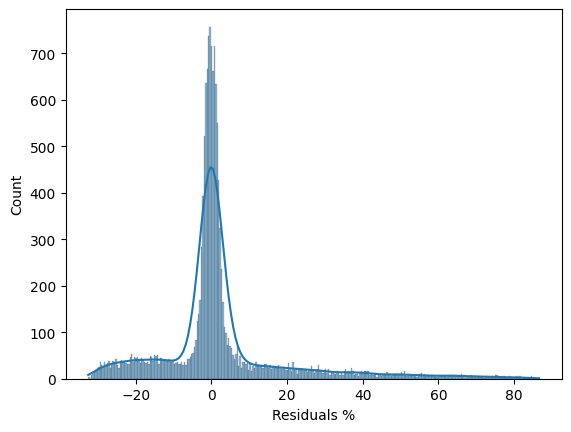

In [ ]:
sns.histplot(results_df['Residuals %'], kde=True)

The error range is really high because the model is predicting the premium to be 80% high in few cases. This is not going to be good in terms of customer satisfaction.

Let's decide a threshold of 10%. Errors should not be more than 10%. If we have errors more than 10% then that number should be very minimal.

In [ ]:
# Get the recorda that have more than 10% margin of error
error_threshold = 10
high_error_records = results_df[np.abs(results_df['Residuals %']) > error_threshold]
high_error_records.shape

(4444, 4)

In [ ]:
# Percentage of these extreme errors
high_error_pct = (high_error_records.shape[0] / results_df.shape[0]) * 100
high_error_pct

29.66622162883845

Almost 30% of models predictions are high errors.

In [ ]:
# Check how many records have > 50% error margin
results_df[np.abs(results_df['Residuals %']) > 50].sort_values(by='Residuals %', ascending=False)

,Actual,Predicted,Residuals,Residuals %
36269,3501,6532.543457,3031.543457,86.590787
29904,3503,6528.993164,3025.993164,86.382905
898,3602,6689.325684,3087.325684,85.711429
7988,3527,6528.503906,3001.503906,85.100763
18094,3505,6487.236816,2982.236816,85.085216
...,...,...,...,...
2796,4234,6356.967285,2122.967285,50.140937
7174,4349,6529.018066,2180.018066,50.126881
14216,5167,7755.677734,2588.677734,50.100208
25604,4930,7397.707031,2467.707031,50.054909


This model cannot be deployed. Further analysis is required.

In [ ]:
# high_error_records are the records in X_test. Get these high_error_records from X_test
high_error_records_df = X_test.loc[high_error_records.index]
high_error_records_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
15052,0.055556,0.0,0.040404,0.5,0.0,0,0,0,1,1,0,1,0,0,0,0,0
46792,0.092593,0.0,0.202020,0.5,0.0,0,0,1,0,1,0,1,0,0,0,0,0
14379,0.018519,0.2,0.666667,0.5,0.0,1,0,0,1,1,0,0,1,0,0,0,0
28659,0.092593,0.2,0.040404,0.0,1.0,1,1,0,0,1,0,0,0,0,0,1,0
17255,0.000000,0.0,0.020202,0.5,0.0,1,0,0,0,1,0,0,0,0,1,0,0


In [ ]:
high_error_records_df.shape

(4444, 17)

Let us check if error rate is high in specific income group.

<Axes: xlabel='income_lakhs', ylabel='Count'>

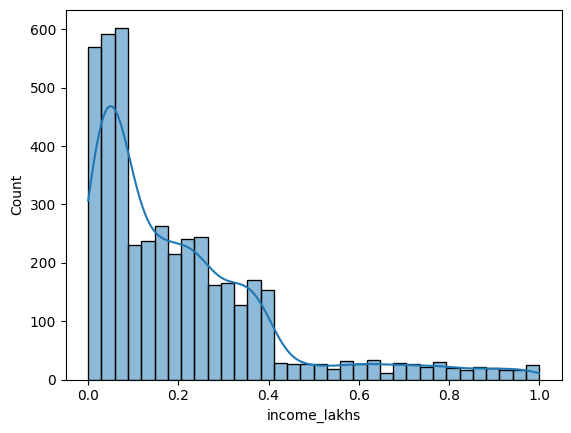

In [ ]:
#Plot a histogram for income_lakhs in high_error_records_df
sns.histplot(high_error_records_df['income_lakhs'], kde=True)

Based on the above chart, it is hard to predict. It is not insightful.
It will be useful if we can plot both error distribution and X-test distribution in one graph. If the distribution graph looks same, then there is no problem with the feature. But if the distribution in the X_test shape and error distribution shape is not similar then it can be said that, that particular feature or that particular group where shape doesn't look similar has some problem (or error rate is high for particular set then the problem persists there.)

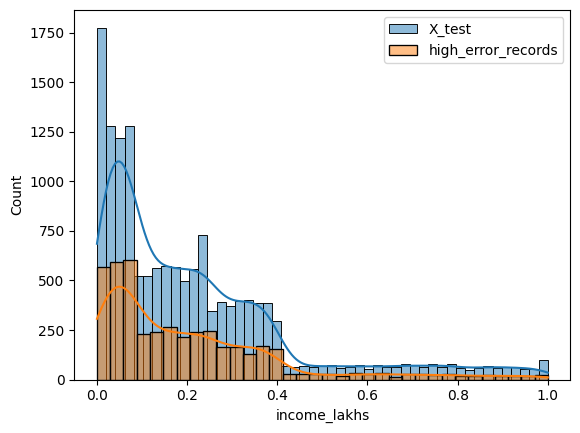

In [ ]:
sns.histplot(X_test['income_lakhs'], kde=True, label='X_test')
sns.histplot(high_error_records_df['income_lakhs'], kde=True, label='high_error_records')
plt.legend()
plt.show()

X-test shape and high_records_error shape is kind of similar. The errors are spread across all the income groups in equal fashion. Let us try for the other features as well.

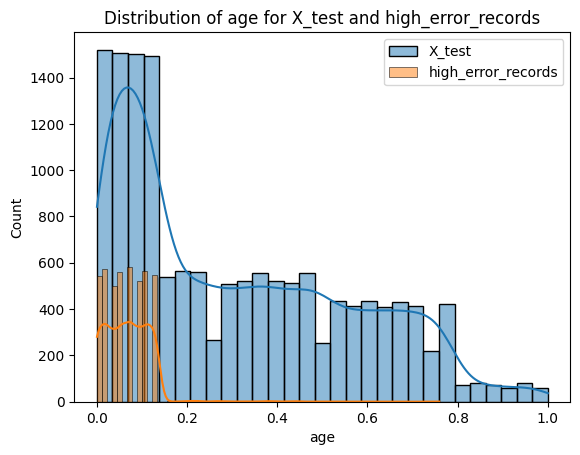

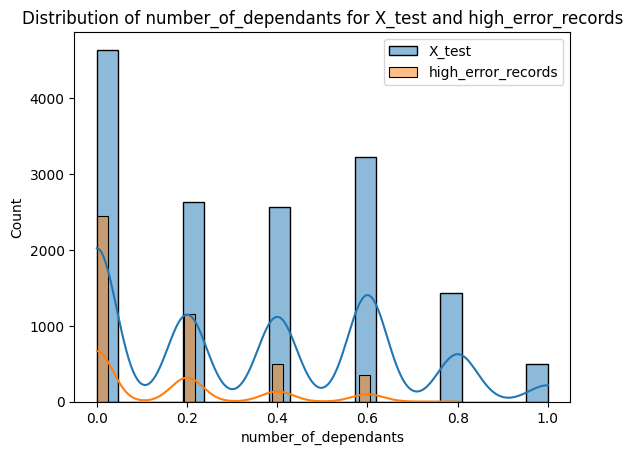

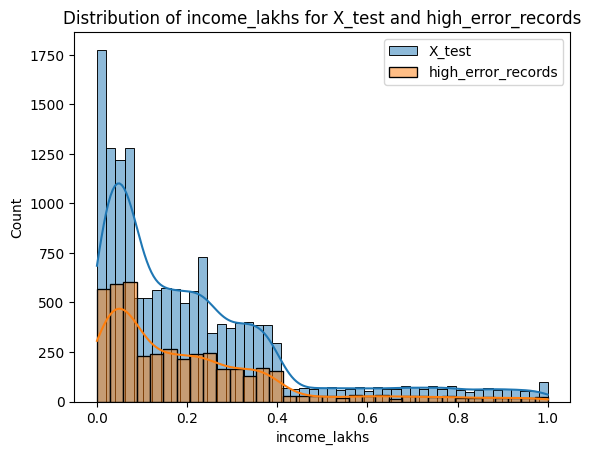

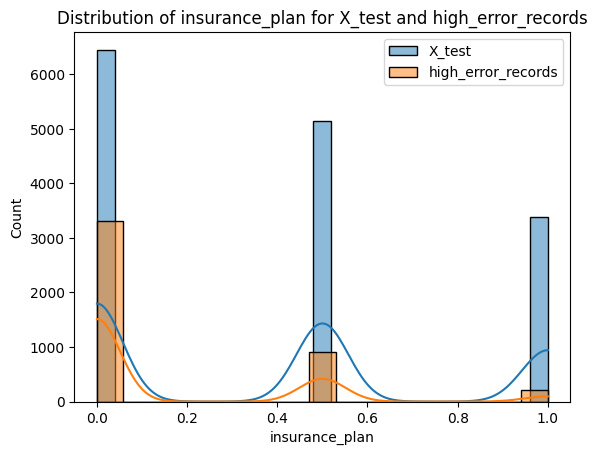

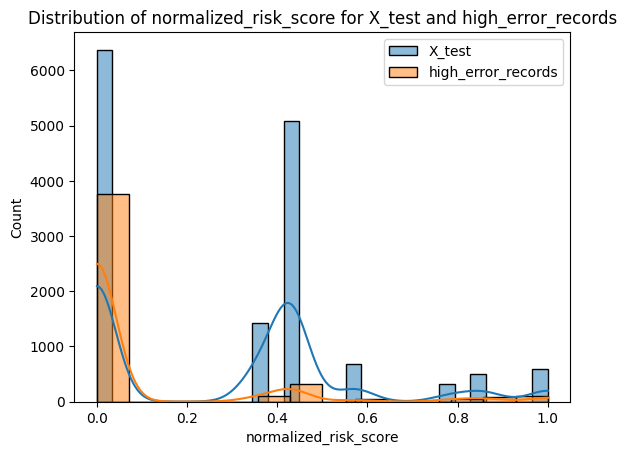

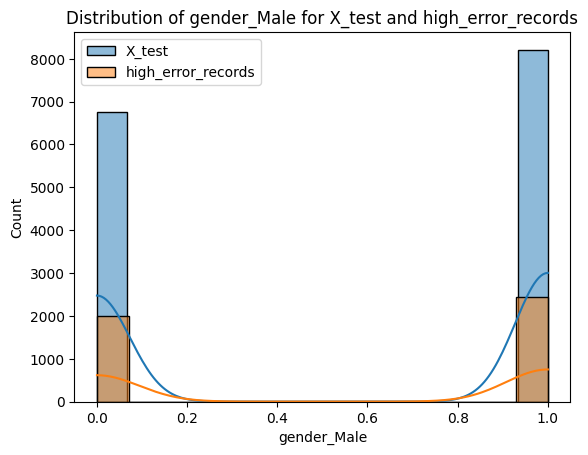

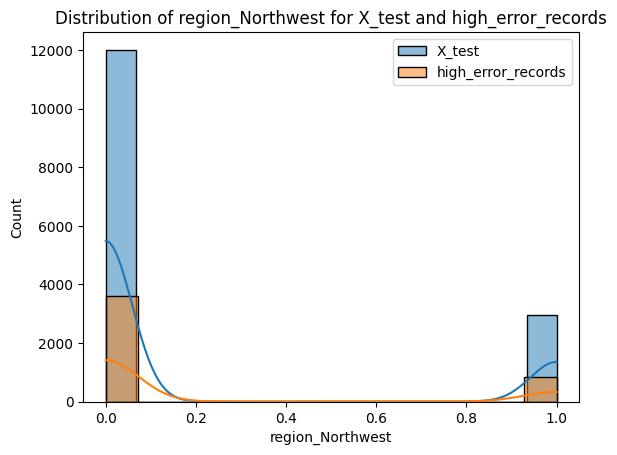

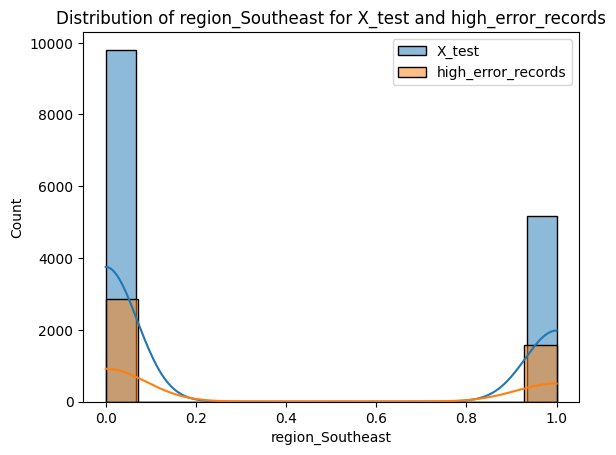

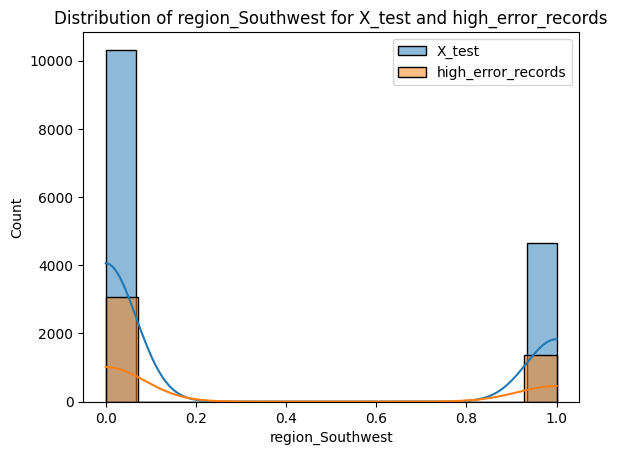

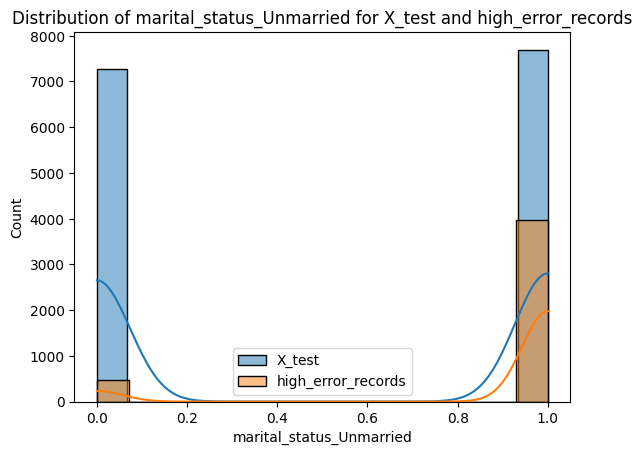

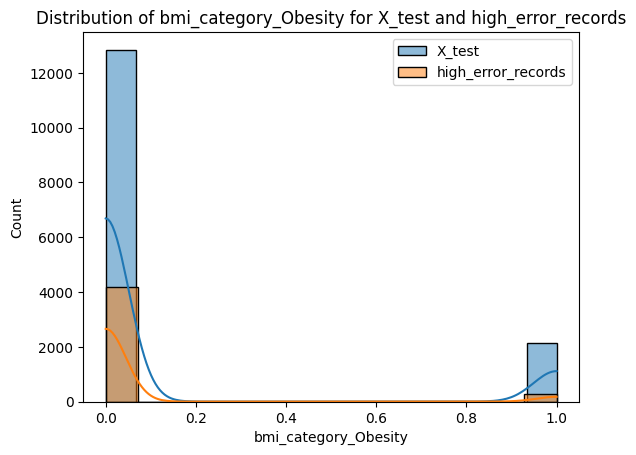

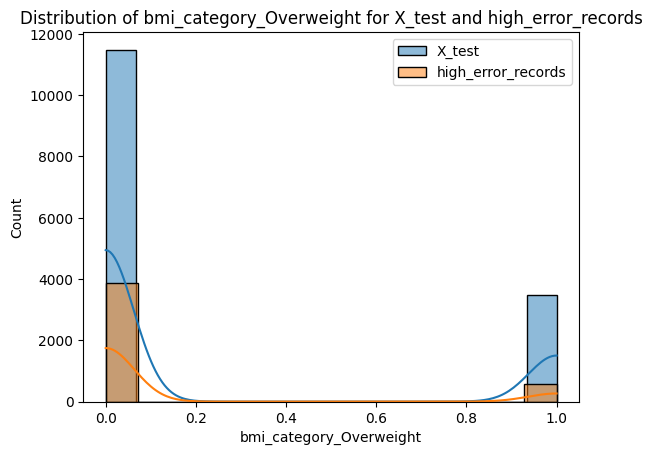

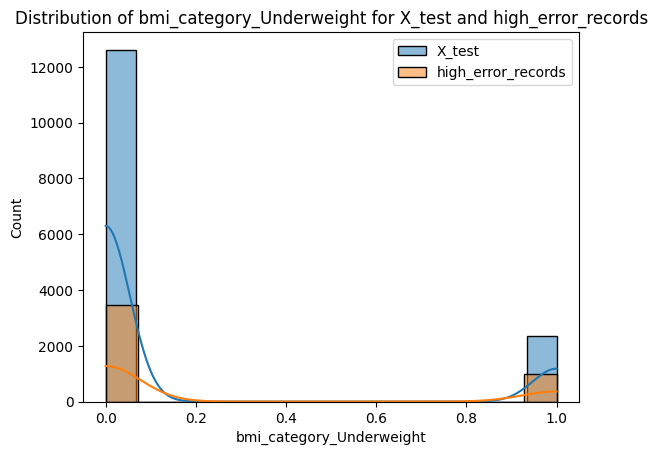

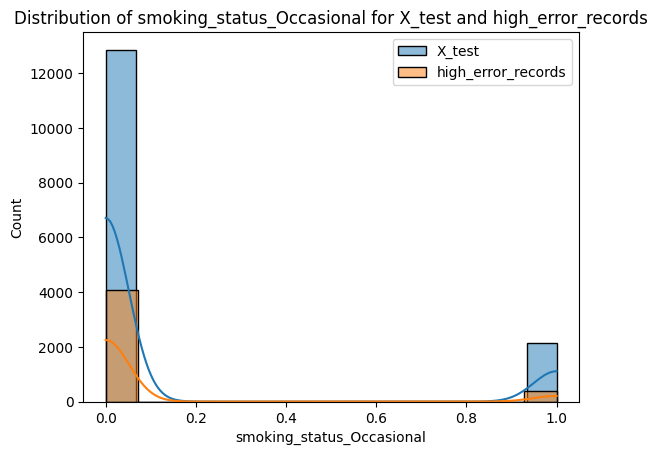

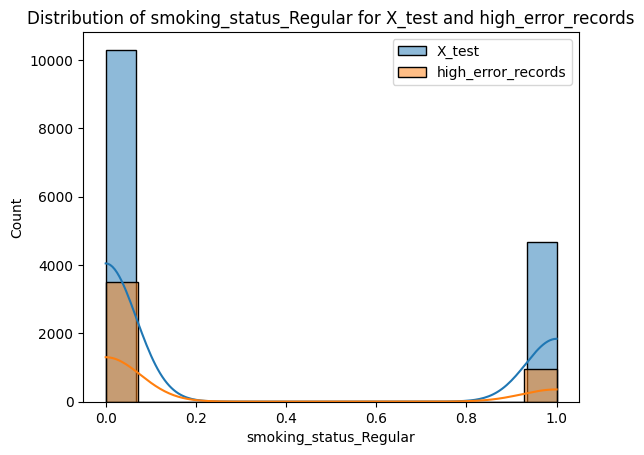

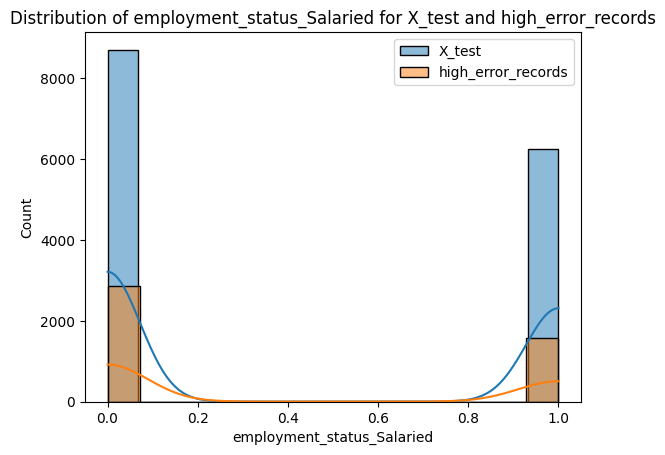

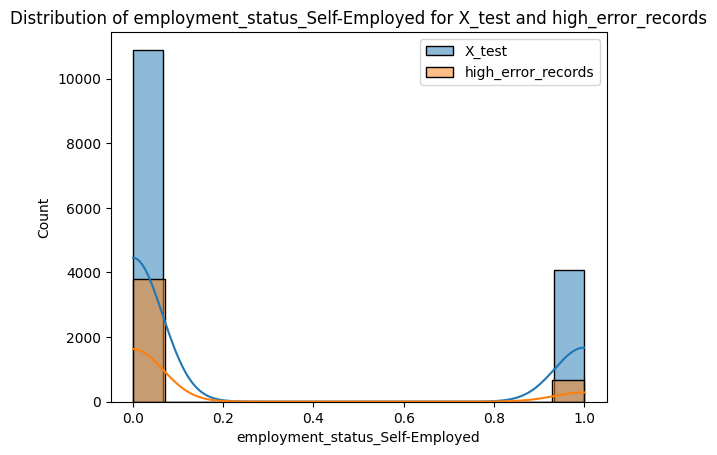

In [ ]:
for feature in X_test.columns:
  sns.histplot(X_test[feature], kde=True, label='X_test')
  sns.histplot(high_error_records_df[feature], kde=True, label='high_error_records')
  plt.legend()
  plt.title(f'Distribution of {feature} for X_test and high_error_records')
  plt.show()

The shapes for most of the features is similar other than age.

The distribution of age in X_test and high_error_records doesn't look similar. The errors are high in lower age group. So, extreme errors are centerd in the lower age group.

<Axes: xlabel='age', ylabel='Count'>

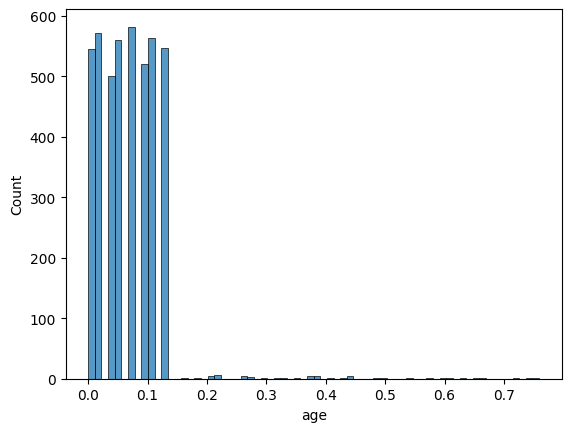

In [ ]:
#Check which age group has error rate
sns.histplot(high_error_records_df['age'])

cols_to_scale = ['age','number_of_dependants','income_level','income_lakhs','insurance_plan']

In [ ]:
#Since income_level column is dropped, I have to add that column again (No need to worry about the value.)
high_error_records_df['income_level'] = -1

#Check the age group by reverse scaling
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(high_error_records_df[cols_to_scale])

In [ ]:
df_reversed

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,21.0,0.0,-2.0,5.0,2.0
1,23.0,0.0,-2.0,21.0,2.0
2,19.0,1.0,-2.0,67.0,2.0
3,23.0,1.0,-2.0,5.0,1.0
4,18.0,0.0,-2.0,3.0,2.0
...,...,...,...,...,...
4439,18.0,0.0,-2.0,6.0,1.0
4440,22.0,0.0,-2.0,27.0,1.0
4441,24.0,0.0,-2.0,21.0,1.0
4442,21.0,0.0,-2.0,29.0,2.0


<Axes: xlabel='age', ylabel='Count'>

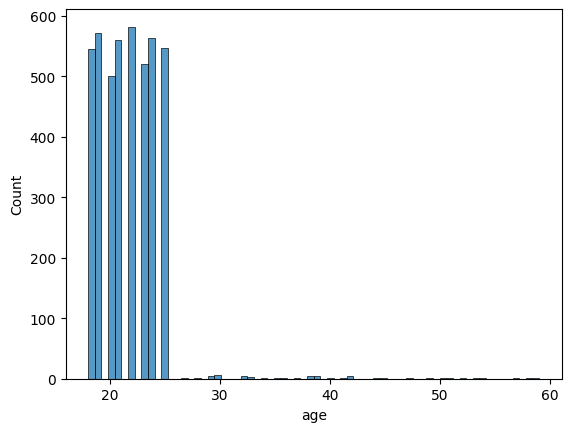

In [ ]:
sns.histplot(df_reversed['age'])

Till 25 age group, there is some error

In [ ]:
df_reversed.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
count,4444.000000,4444.000000,4444.0,4444.000000,4444.000000
mean,21.717597,0.720747,-2.0,21.268677,1.300630
std,3.108822,0.951496,0.0,20.519097,0.552521
min,18.000000,0.000000,-2.0,1.000000,1.000000
25%,19.000000,0.000000,-2.0,6.000000,1.000000
50%,22.000000,0.000000,-2.0,15.000000,1.000000
75%,24.000000,1.000000,-2.0,30.000000,2.000000
max,59.000000,4.000000,-2.0,100.000000,3.000000


Here it is clear that 75% of data points are of age 24 or less.

In [ ]:
# # Calculate the quantile for the maximum age that is <= 25
# max_age_25 = df_reversed[df_reversed['age'] <= 25]['age'].max()

# # Calculate the rank (percentile) of this maximum age in the entire dataset
# quantile_value = df_reversed['age'].rank(pct=True).loc[df_reversed['age'] == max_age_25].max()

# print(f"The quantile corresponding to age {max_age_25} is: {quantile_value * 100:.2f}%")


The quantile corresponding to age 25.0 is: 92.61%


Use the Above Approach if you want to know where the largest value (25 or below) ranks within the entire dataset (e.g., "What's the percentile rank of age 25 in this dataset?").

In [ ]:
# Calculate the proportion of values where age <= 25
quantile_value = (df_reversed['age'] <= 25).mean()

# Print the quantile value as a percentage
print(f"The quantile corresponding to age <= 25: {quantile_value * 100:.2f}%")

The quantile corresponding to age <= 25: 98.74%


Use the Above Approach if you want to know what proportion of the dataset has age ≤ 25 — i.e., the cumulative quantile up to age 25.

The quantile corresponding to age <= 25: 98.74%
So, about 99% are <=25 years old. This has to be handled. One way to do that is model segmentation. For age<=25, use one model and for the rest use another model.

From Regression2 notebook we got 2 excel files 'young_premiums.xlsx' (in this file age<=25) and 'rest_premiums.xlsx'(in this file age>25).

* Change the initial df here and check for both excel files. With 'young_premiums.xlsx' it can be seen that, the errors in age are spread across. The errors are spread across 18-25. To reduce the erros further, we can either perform different feature engineering or collect more data (more data or more features) because the features here are clearly not able to catch the variance in target variable. XGBoost r2 score is 0.56 for test score. The error percentage is 73%

* If we copy this notebook and run the same analysis (like the one in this notebook), it is pretty clear that rest_premium.xlsx, the linear regression gave r2 score of 0.95 and for XGBoost r2 score  is 0.99. The extreme error analysis is within 10% threshold range. So, this model for rest_premium.xlsx is working amazingly well and the error percentage is 0.3%.

